In [1]:
!pip install gensim
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install pandas numpy
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [3]:
df=pd.read_csv(r'/content/data.csv')

In [4]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [6]:
df.shape

(5842, 2)

In [7]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,"Operating loss totalled EUR 0.9 mn , down from...",neutral
freq,2,3130


## Handling Duplicates

In [8]:
df.duplicated().sum()

6

In [9]:
df = df.drop_duplicates()

In [10]:
df.isnull().sum()

,0
Sentence,0
Sentiment,0


In [11]:
df['Sentiment'].value_counts()

,count
Sentiment,
neutral,3124
positive,1852
negative,860


In [12]:
X = df['Sentence']
y = df['Sentiment']

<Axes: xlabel='Sentiment', ylabel='count'>

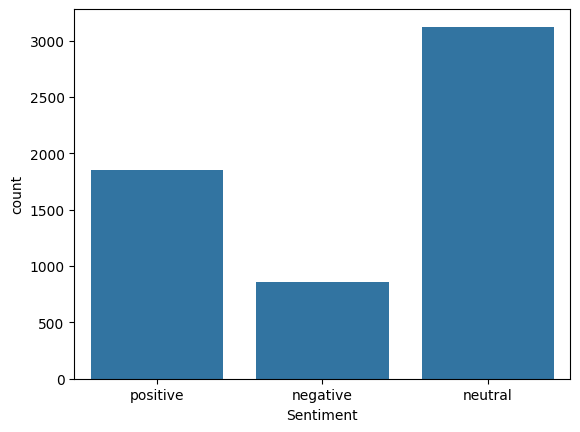

In [13]:
sns.countplot(data=df,x=y)

## Importing all the dependencies

In [58]:
# (Colab) install gensim if needed; skip this line if gensim already installed locally
!pip install -q gensim

# Imports
import re
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility seeds (optional)
np.random.seed(42)
tf.random.set_seed(42)


In [49]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

In [52]:
df

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",2
3,According to the Finnish-Russian Chamber of Co...,1
4,The Swedish buyout firm has sold its remaining...,1
...,...,...
5837,RISING costs have forced packaging producer Hu...,0
5838,Nordic Walking was first used as a summer trai...,1
5839,"According shipping company Viking Line , the E...",1
5840,"In the building and home improvement trade , s...",1


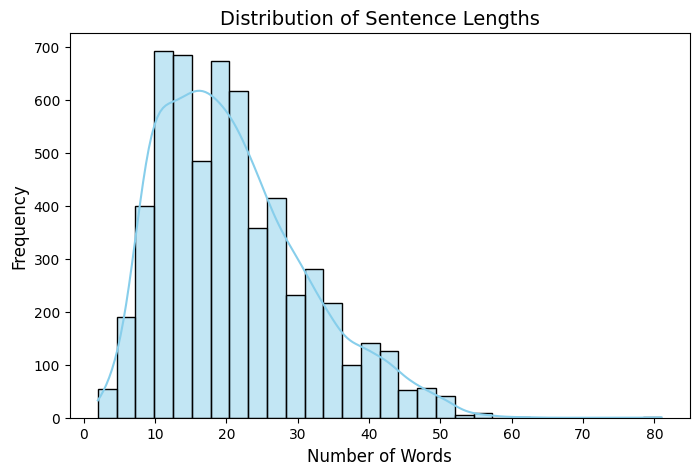

In [53]:
# Add a new column for sentence length (in words)
df['sentence_length'] = df['Sentence'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
plt.figure(figsize=(8, 5))
sns.histplot(df['sentence_length'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Sentence Lengths", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

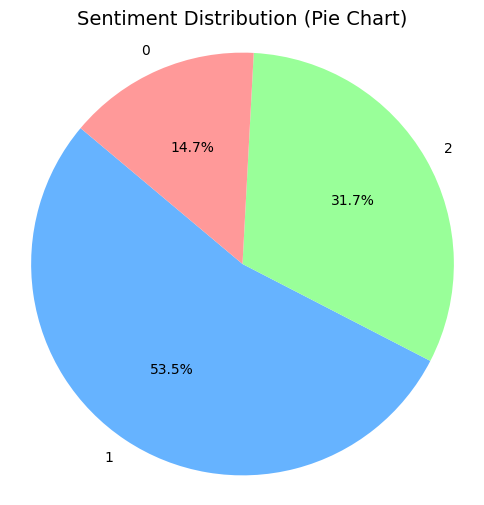

In [54]:
# Count the number of each sentiment
sentiment_counts = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%',
        startangle=140, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title("Sentiment Distribution (Pie Chart)", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

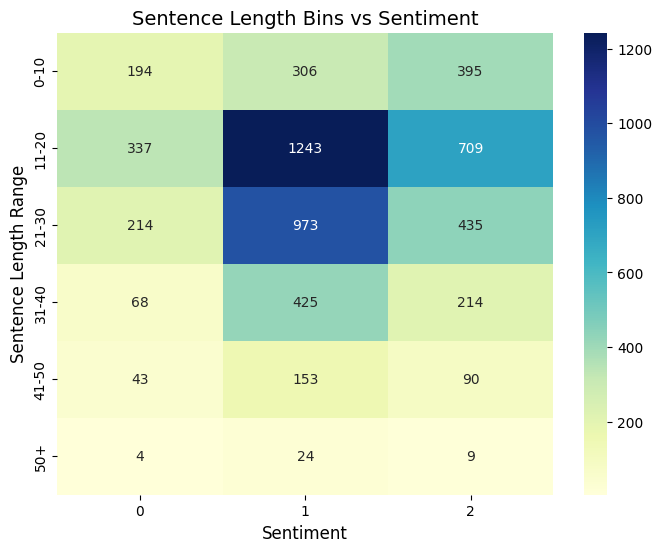

In [55]:
# Create bins for sentence lengths
df['length_bin'] = pd.cut(df['sentence_length'], bins=[0,10,20,30,40,50,100],
                          labels=['0-10','11-20','21-30','31-40','41-50','50+'])

# Cross-tabulation of Sentiment and Length Bins
heat_data = pd.crosstab(df['length_bin'], df['Sentiment'])

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(heat_data, annot=True, cmap="YlGnBu", fmt='d')
plt.title("Sentence Length Bins vs Sentiment", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Sentence Length Range", fontsize=12)
plt.show()

## Word2Vec Embeddings

In [59]:
# Basic robust cleaner. Keeps only alphabetic tokens; replaces -,/ with space; lowercases.
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+|https\S+', ' ', s)   # remove URLs
    s = re.sub(r'[@#\$]\w+', ' ', s)                # remove handles/tickers/hashtags tokens
    s = re.sub(r'[-/]', ' ', s)                     # replace hyphen/slash with space
    s = re.sub(r'[^a-z\s]', ' ', s)                 # keep letters and spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply cleaning, drop nulls/dups
df['clean'] = df['Sentence'].astype(str).apply(clean_text)
df.dropna(subset=['clean', 'Sentiment'], inplace=True)
df.drop_duplicates(subset=['clean', 'Sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Samples after cleaning:", len(df))
df.head(3)


Samples after cleaning: 5775


,Sentence,Sentiment,sentence_length,length_bin,clean
0,The GeoSolutions technology will leverage Bene...,2,32,31-40,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0,11,11-20,on lows down to bk a real possibility
2,"For the last quarter of 2010 , Componenta 's n...",2,39,31-40,for the last quarter of componenta s net sales...


In [60]:
# Tokenize per sentence for Word2Vec
tokenized_corpus = [s.split() for s in df['clean'].tolist()]

EMB_DIM = 100   # embedding size (resume-friendly: "100-d Word2Vec")
w2v = Word2Vec(sentences=tokenized_corpus, vector_size=EMB_DIM, window=5, min_count=1, workers=4, sg=1)
w2v.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=10)

print("Word2Vec trained. Vocab size (w2v):", len(w2v.wv))

Word2Vec trained. Vocab size (w2v): 9620


## Tokenizer and Padding

In [61]:
# Build tokenizer aligned with Keras
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean'].tolist())
sequences = tokenizer.texts_to_sequences(df['clean'].tolist())

# Determine dynamic max_len (95th percentile, clamped)
lengths = [len(s) for s in sequences]
max_len = int(np.percentile(lengths, 95))
max_len = max(10, min(300, max_len))   # keep within reasonable range
print("Using max_len =", max_len)

X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post', value=0)

# Vocabulary size aligned with tokenizer
vocab_size = len(tokenizer.word_index) + 1   # +1 for padding index 0
print("Vocab size (tokenizer):", vocab_size)

Using max_len = 35
Vocab size (tokenizer): 9622


In [62]:
# Create embedding matrix shape (vocab_size, EMB_DIM)
# Row 0 -> PAD zeros; missing words init small random vector
rng = np.random.default_rng(42)
embedding_matrix = rng.normal(loc=0.0, scale=0.05, size=(vocab_size, EMB_DIM)).astype(np.float32)
embedding_matrix[0] = np.zeros((EMB_DIM,), dtype=np.float32)  # PAD vector zeros

# Fill with Word2Vec vectors when available
miss = 0
for word, idx in tokenizer.word_index.items():
    # tokenizer.word_index maps words to indices starting from 1
    if word in w2v.wv:
        embedding_matrix[idx] = w2v.wv[word]
    else:
        miss += 1

print(f"Embedding matrix ready. Shape: {embedding_matrix.shape}. Missing words (random init): {miss}")
# Sanity: embedding_matrix.shape[0] must equal vocab_size
assert embedding_matrix.shape[0] == vocab_size


Embedding matrix ready. Shape: (9622, 100). Missing words (random init): 1


In [63]:
# Encode labels to integer classes (sparse classification)
le = LabelEncoder()
y_int = le.fit_transform(df['Sentiment'].astype(str).values)
classes = list(le.classes_)
num_classes = len(classes)
print("Classes:", classes, "| num_classes:", num_classes)

# Train-test split (stratify)
X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.20, random_state=42, stratify=y_int)
print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])


Classes: ['0', '1', '2'] | num_classes: 3
Train / Test sizes: 4620 1155


In [64]:
class_weights_vals = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_vals)}
print("Class weights:", class_weights)

Class weights: {0: 2.271386430678466, 1: 0.6204673650282031, 2: 1.0547945205479452}


## LSTM Training

In [78]:
# --- LSTM Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Build model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size,
                         output_dim=EMB_DIM,
                         weights=[embedding_matrix],
                         trainable=False))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile
model_lstm.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

model_lstm.build(input_shape=(None, max_len))
model_lstm.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 35, 100)        │       962,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,087,899 (4.15 MB)

 Trainable params: 125,699 (491.01 KB)

 Non-trainable params: 962,200 (3.67 MB)

In [79]:
# Train
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_lstm = model_lstm.fit(X_train, y_train,
                              validation_split=0.1,
                              epochs=40,
                              batch_size=64,
                              class_weight=class_weights,
                              callbacks=[es],
                              verbose=1)

# Evaluate
loss, acc = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM test accuracy: {acc:.4f} | loss: {loss:.4f}")

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3890 - loss: 1.0846 - val_accuracy: 0.5065 - val_loss: 0.9237
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5181 - loss: 0.9775 - val_accuracy: 0.5281 - val_loss: 0.9006
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5197 - loss: 0.9529 - val_accuracy: 0.5519 - val_loss: 0.8713
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5346 - loss: 0.9298 - val_accuracy: 0.5801 - val_loss: 0.8926
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5426 - loss: 0.9103 - val_accuracy: 0.5887 - val_loss: 0.8269
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5661 - loss: 0.9161 - val_accuracy: 0.6342 - val_loss: 0.7780
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5734 - loss: 0.8844 - val_accuracy: 0.6126 - val_loss: 0.8175
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6071 - loss: 0.8603 - val_accuracy: 0.6407 - val_loss

## Bi-LSTM

In [81]:
# --- Bi-LSTM Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# Build model
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=vocab_size,
                           output_dim=EMB_DIM,
                           weights=[embedding_matrix],
                           trainable=False))
model_bilstm.add(Bidirectional(LSTM(128, return_sequences=False)))
model_bilstm.add(Dropout(0.4))
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile
model_bilstm.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Build model explicitly
model_bilstm.build(input_shape=(None, max_len))
model_bilstm.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 35, 100)        │       962,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,339 (4.63 MB)

 Trainable params: 251,139 (981.01 KB)

 Non-trainable params: 962,200 (3.67 MB)

In [83]:
# Train
history_bilstm = model_bilstm.fit(X_train, y_train,
                                  validation_split=0.1,
                                  epochs=40,
                                  batch_size=64,
                                  class_weight=class_weights,
                                  callbacks=[es],
                                  verbose=1)

# Evaluate
loss, acc = model_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"Bi-LSTM test accuracy: {acc:.4f} | loss: {loss:.4f}")

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4502 - loss: 1.0558 - val_accuracy: 0.5714 - val_loss: 0.9076
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5571 - loss: 0.9431 - val_accuracy: 0.5671 - val_loss: 0.8788
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5676 - loss: 0.9080 - val_accuracy: 0.5693 - val_loss: 0.8568
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5739 - loss: 0.8948 - val_accuracy: 0.5887 - val_loss: 0.8602
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6122 - loss: 0.8687 - val_accuracy: 0.5671 - val_loss: 0.8481
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6062 - loss: 0.8478 - val_accuracy: 0.5909 - val_loss: 0.8302
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6224 - loss: 0.8194 - val_accuracy: 0.5801 - val_loss: 0.8313
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6379 - loss: 0.8083 - val_accuracy: 0.5693 - val_

## Gated Recurrent Units (GRU's)

In [82]:
# --- GRU Model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Build model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size,
                        output_dim=EMB_DIM,
                        weights=[embedding_matrix],
                        trainable=False))
model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.4))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(len(np.unique(y_train)), activation='softmax'))

# Compile
model_gru.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Build model explicitly
model_gru.build(input_shape=(None, max_len))
model_gru.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 35, 100)        │       962,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,971 (4.04 MB)

 Trainable params: 96,771 (378.01 KB)

 Non-trainable params: 962,200 (3.67 MB)

In [84]:
# Train
history_gru = model_gru.fit(X_train, y_train,
                            validation_split=0.1,
                            epochs=40,
                            batch_size=64,
                            class_weight=class_weights,
                            callbacks=[es],
                            verbose=1)

# Evaluate
loss, acc = model_gru.evaluate(X_test, y_test, verbose=0)
print(f"GRU test accuracy: {acc:.4f} | loss: {loss:.4f}")

Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2875 - loss: 1.1042 - val_accuracy: 0.2056 - val_loss: 1.0945
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3789 - loss: 1.0946 - val_accuracy: 0.4156 - val_loss: 1.0245
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4828 - loss: 1.0353 - val_accuracy: 0.4848 - val_loss: 0.9474
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5120 - loss: 0.9875 - val_accuracy: 0.5346 - val_loss: 0.8971
Epoch 5/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5425 - loss: 0.9699 - val_accuracy: 0.5281 - val_loss: 0.9007
Epoch 6/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5419 - loss: 0.9592 - val_accuracy: 0.5173 - val_loss: 0.8814
Epoch 7/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5344 - loss: 0.9463 - val_accuracy: 0.5325 - val_loss: 0.8815
Epoch 8/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5385 - loss: 0.9349 - val_accuracy: 0.5390 - val_loss

In [85]:
def get_best_accuracy(history, model, X_test, y_test):
    best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    best_val_acc = history.history['val_accuracy'][best_epoch]
    best_train_acc = history.history['accuracy'][best_epoch]

    # Evaluate on test set
    loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    return {
        'best_epoch': best_epoch + 1,  # epochs are 1-indexed
        'best_train_acc': best_train_acc,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc
    }

# LSTM
lstm_best = get_best_accuracy(history_lstm, model_lstm, X_test, y_test)
# BiLSTM
bilstm_best = get_best_accuracy(history_bilstm, model_bilstm, X_test, y_test)
# GRU
gru_best = get_best_accuracy(history_gru, model_gru, X_test, y_test)

# Display
print("LSTM Best Accuracy:", lstm_best)
print("BiLSTM Best Accuracy:", bilstm_best)
print("GRU Best Accuracy:", gru_best)


LSTM Best Accuracy: {'best_epoch': 12, 'best_train_acc': 0.6418951153755188, 'best_val_acc': 0.6558441519737244, 'test_acc': 0.6190476417541504}
BiLSTM Best Accuracy: {'best_epoch': 22, 'best_train_acc': 0.7270322442054749, 'best_val_acc': 0.6406926512718201, 'test_acc': 0.6536796689033508}
GRU Best Accuracy: {'best_epoch': 22, 'best_train_acc': 0.7145262360572815, 'best_val_acc': 0.6818181872367859, 'test_acc': 0.6329004168510437}
